<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [1]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Mounted at /content/drive


In [ ]:
!pip install dask[dataframe]

In [2]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load data and Best LightGBM Models

Sets of features (data columns)

In [4]:
#MASTER DATASET

META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = ['payment_type', 'days_since_request', 'bank_branch_count_8w', 'credit_risk_score', 'source', 'device_os', 'device_fraud_count','month']
SEN = ['customer_age', 'income', 'employment_status'] #protected attributes in BAF paper
PROX = ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'zip_count_4w', 'date_of_birth_distinct_emails_4w',
        'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request', 'session_length_in_minutes',
        'device_distinct_emails']

ERROR_scaled = ['errors_scaled']
REG_scaled = ['payment_type_scaled', 'days_since_request_scaled', 'bank_branch_count_8w_scaled', 'credit_risk_score_scaled',
              'source_scaled', 'device_os_scaled', 'device_fraud_count_scaled','month_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled', 'employment_status_scaled']
PROX_scaled = [['name_email_similarity_scaled', 'prev_address_months_count_scaled', 'current_address_months_count_scaled', 'zip_count_4w_scaled',
                'date_of_birth_distinct_emails_4w_scaled','housing_status_scaled', 'phone_home_valid_scaled', 'phone_mobile_valid_scaled',
                'bank_months_count_scaled', 'has_other_cards_scaled', 'foreign_request_scaled', 'session_length_in_minutes_scaled', 'device_distinct_emails_scaled']]

'''Removed features:
intended_balcon_amount
velocity_6h
velocity_24h
velocity_4w
email_is_free
proposed_credit_limit
keep_alive_session
'''

'Removed features:\nintended_balcon_amount\nvelocity_6h\nvelocity_24h\nvelocity_4w\nemail_is_free\nproposed_credit_limit\nkeep_alive_session\n'

In [3]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [9]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [10]:
#remove features
features_to_remove = ['intended_balcon_amount', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'email_is_free', 'proposed_credit_limit', 'keep_alive_session']

for df_name, df in dataframes.items():
  for column in features_to_remove:
    if column in df.columns:
      df.drop(column, axis=1, inplace=True)


In [11]:
variant1.iloc[500]

,500
fraud_bool,0
income,0.3
name_email_similarity,0.128825
prev_address_months_count,-1
current_address_months_count,77
customer_age,20
days_since_request,0.008666
payment_type,AB
zip_count_4w,3565
bank_branch_count_8w,13


In [12]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Base_top_4.pkl
Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant II_top_4.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant V_top_0.pkl
Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant I_top_4.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant III_top_0.pkl
Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant IV_top_6.pkl


# Pre-process

In [13]:
#base.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,bank_branch_count_8w,...,phone_mobile_valid,bank_months_count,has_other_cards,foreign_request,source,session_length_in_minutes,device_os,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,AA,1059,5,...,1,9,0,0,INTERNET,16.224843,linux,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,AD,1658,3,...,1,2,0,0,INTERNET,3.363854,other,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,AB,1095,15,...,1,30,0,0,INTERNET,22.730559,windows,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,AB,3483,11,...,1,1,0,0,INTERNET,15.215816,linux,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,AA,2339,1,...,1,26,0,0,INTERNET,3.743048,other,1,0,0


In [14]:
base['payment_type']

,payment_type
0,AA
1,AD
2,AB
3,AB
4,AA
...,...
999995,AB
999996,AC
999997,AA
999998,AB


In [8]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [9]:
def convert_object_to_num(data):
    for column in data.select_dtypes(include=['object']).columns:
        # Convert object to boolean if the values are binary (0/1)
        if data[column].isin([0, 1]).all():  # Checks if the column contains only 0s and 1s
            data[column] = data[column].astype(bool)  # Convert to boolean (True/False)

        # Otherwise, convert to numeric (int or float)
        else:
            try:
                data[column] = pd.to_numeric(data[column], errors='raise', downcast='integer')
            except ValueError:
                # If conversion fails to int, try float
                try:
                    data[column] = pd.to_numeric(data[column], errors='raise', downcast='float')
                except ValueError:
                    # If numeric conversion fails, coerce errors to NaN (handle invalid strings)
                    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

In [10]:
base_df_cleaned = convert_object_to_num(test_dfs['Base'])
variant1_df_cleaned = convert_object_to_num(test_dfs['Variant I'])
variant2_df_cleaned = convert_object_to_num(test_dfs['Variant II'])
variant3_df_cleaned = convert_object_to_num(test_dfs['Variant III'])
variant4_df_cleaned = convert_object_to_num(test_dfs['Variant IV'])
variant5_df_cleaned = convert_object_to_num(test_dfs['Variant V'])
base_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205011 entries, 940541 to 960672
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        205011 non-null  int64  
 1   income                            205011 non-null  float64
 2   name_email_similarity             205011 non-null  float64
 3   prev_address_months_count         205011 non-null  int64  
 4   current_address_months_count      205011 non-null  int64  
 5   customer_age                      205011 non-null  int64  
 6   days_since_request                205011 non-null  float64
 7   intended_balcon_amount            205011 non-null  float64
 8   payment_type                      0 non-null       float64
 9   zip_count_4w                      205011 non-null  int64  
 10  velocity_6h                       205011 non-null  float64
 11  velocity_24h                      205011 non-null  f

# Get the Errors

In [11]:
def get_errors (model, data, test_dfs):
    """
    Evaluate trained model on test data and compute metrics and errors.
    - model: Trained model (Best LightGBM model)
    - X_test: Feature matrix for the test data
    - Y_test: True labels for the test data

    Returns:
    - metrics: Dictionary containing calculated metrics (accuracy, precision, recall, f1, ROC AUC)
    - predictions: DataFrame containing the true and predicted classes along with errors
    """

    #get train and test data
    X_train = train_dfs[data].drop(columns=["fraud_bool"])
    Y_train = train_dfs[data]["fraud_bool"]
    X_test = test_dfs[data].drop(columns=["fraud_bool"])
    Y_test = test_dfs[data]["fraud_bool"]

    #predict
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

    # Convert predictions and true labels to integers if they are not already
    Y_pred = Y_pred.astype(int)  # Ensure predictions are integers (0 or 1)
    Y_test = Y_test.astype(int)  # Ensure true labels are integers (0 or 1)

   #get evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    #Print the evaluation metrics & confusion matrix
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Create predictions DataFrame
    predictions = pd.DataFrame({
        'predicted_class': Y_pred,
        'true_class': Y_test,
        'errors': abs(Y_pred - Y_test)
    }, index=X_test.index)

    # Merge predictions with the original test data
    test_dfs[data] = pd.merge(test_dfs[data], predictions, left_index=True, right_index=True, how='outer')


    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
    }, predictions

In [12]:
test_dfs['Base']

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
940541,0,0.6,0.783945,10,11,30,1.193113,18.721974,NaN,1984,...,0,200.0,0,NaN,10.489756,NaN,1,1,0,7
906523,0,0.2,0.267486,-1,100,40,0.017005,-0.906182,NaN,772,...,1,500.0,0,NaN,2.558588,NaN,1,1,0,7
973591,1,0.9,0.140937,-1,49,40,0.027693,-0.978197,NaN,728,...,0,500.0,0,NaN,2.227529,NaN,0,1,0,7
938819,0,0.4,0.661991,-1,82,30,0.040481,-0.665699,NaN,899,...,0,1500.0,0,NaN,3.517034,NaN,1,1,0,7
965999,0,0.1,0.381592,-1,33,40,0.006582,-1.920479,NaN,582,...,1,200.0,0,NaN,5.304003,NaN,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920986,0,0.1,0.115959,-1,24,30,0.018352,8.935985,NaN,821,...,1,200.0,0,NaN,2.233129,NaN,1,1,0,7
814067,0,0.9,0.815650,49,4,20,0.004851,-0.497723,NaN,967,...,1,200.0,0,NaN,2.182860,NaN,0,1,0,6
908266,0,0.1,0.386787,9,2,20,2.871814,-1.212351,NaN,79,...,0,200.0,0,NaN,8.618717,NaN,1,1,0,7
868043,0,0.5,0.114277,-1,72,50,0.030777,36.883246,NaN,1073,...,1,200.0,0,NaN,8.482244,NaN,0,1,0,6


Add the metrics and errors to all variants

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9860
Precision: 0.6667
Recall: 0.0007
F1-Score: 0.0014
ROC AUC: 0.8517
Confusion Matrix:
[[202132      1]
 [  2876      2]]


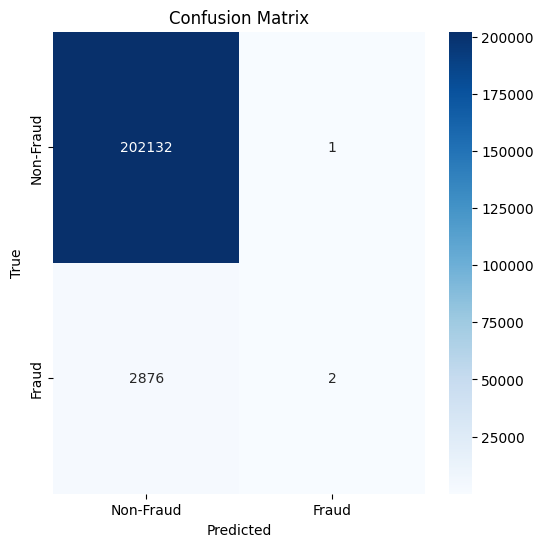

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9860
Precision: 0.6364
Recall: 0.0049
F1-Score: 0.0097
ROC AUC: 0.8507
Confusion Matrix:
[[202124      8]
 [  2864     14]]


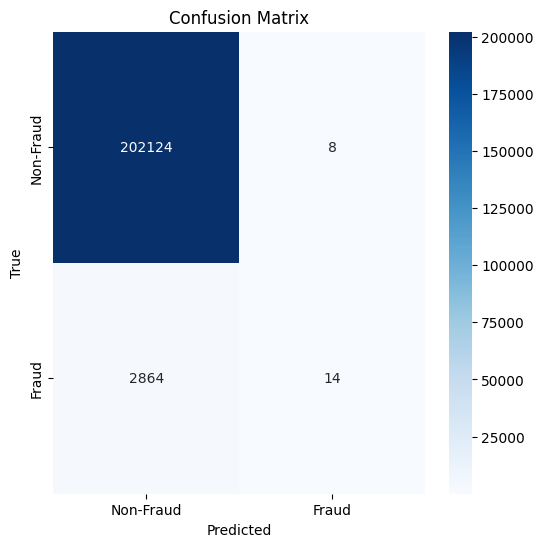

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9860
Precision: 0.6500
Recall: 0.0090
F1-Score: 0.0178
ROC AUC: 0.8636
Confusion Matrix:
[[202118     14]
 [  2852     26]]


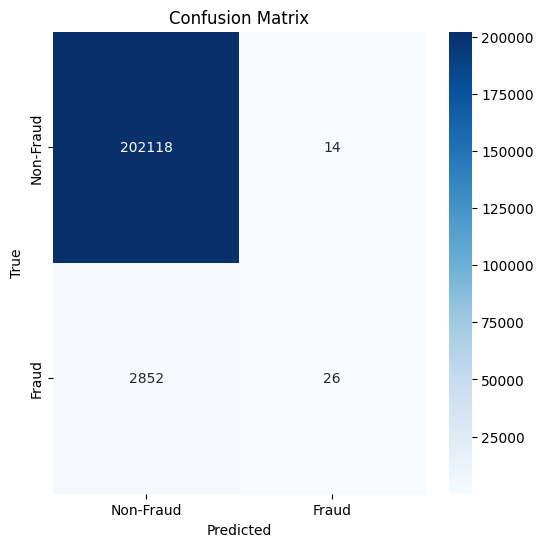

[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9919
Precision: 0.8879
Recall: 0.3047
F1-Score: 0.4537
ROC AUC: 0.9338
Confusion Matrix:
[[238918    102]
 [  1844    808]]


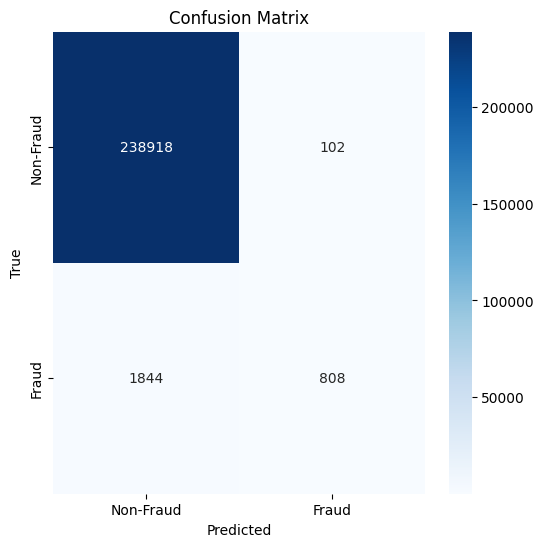

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9890
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.8072
Confusion Matrix:
[[239018      2]
 [  2652      0]]


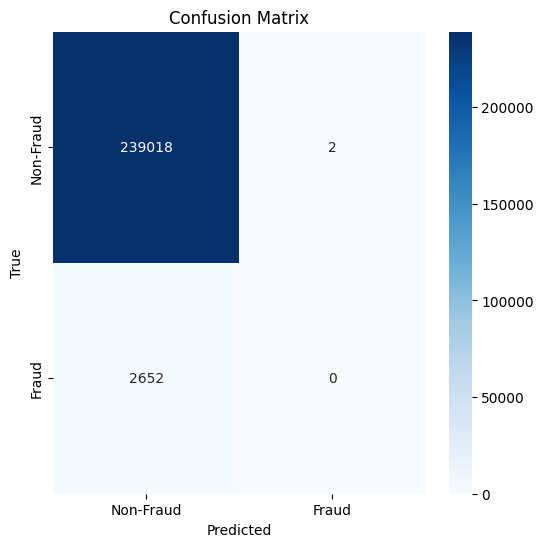

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
Accuracy: 0.9888
Precision: 0.0175
Recall: 0.0004
F1-Score: 0.0007
ROC AUC: 0.6852
Confusion Matrix:
[[238964     56]
 [  2651      1]]


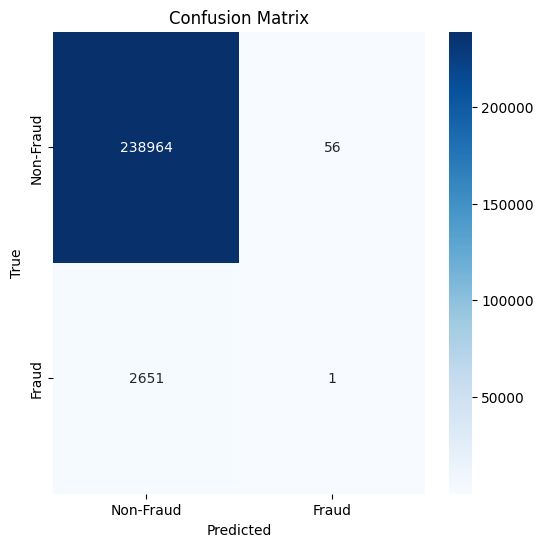

In [13]:
base_metrics, base_error = get_errors(modelb, 'Base', test_dfs)
v1_metrics, v1_error = get_errors(modelv1, 'Variant I', test_dfs)
v2_metrics, v2_error = get_errors(modelv2, 'Variant II', test_dfs)
v3_metrics, v3_error = get_errors(modelv3, 'Variant III', test_dfs)
v4_metrics, v4_error = get_errors(modelv4, 'Variant IV', test_dfs)
v5_metrics, v5_error = get_errors(modelv5, 'Variant V', test_dfs)


#print(test_dfs['Base'].head())  # Includes original columns + true_class, predicted_class, errors
#print(test_dfs['Variant I'].head())  # Includes the same for 'Variant I'

In [14]:
# Rename updated datasets to new variables
Base_error = test_dfs['Base']
V1_error = test_dfs['Variant I']
V2_error = test_dfs['Variant II']
V3_error = test_dfs['Variant III']
V4_error = test_dfs['Variant IV']
V5_error = test_dfs['Variant V']

# Get the error labels

In [15]:
def add_error_labels(df):
    df['TP'] = ((df['true_class'] == 1) & (df['predicted_class'] == 1)).astype(int)
    df['TN'] = ((df['true_class'] == 0) & (df['predicted_class'] == 0)).astype(int)
    df['FN'] = ((df['true_class'] == 1) & (df['predicted_class'] == 0)).astype(int)
    df['FP'] = ((df['true_class'] == 0) & (df['predicted_class'] == 1)).astype(int)
    return df

# Apply the function to each error dataset
Base_error = add_error_labels(Base_error)
V1_error = add_error_labels(V1_error)
V2_error = add_error_labels(V2_error)
V3_error = add_error_labels(V3_error)
V4_error = add_error_labels(V4_error)
V5_error = add_error_labels(V5_error)

In [21]:
Base_error.head()
#Base_error.iloc[500]

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,device_distinct_emails_8w,device_fraud_count,month,predicted_class,true_class,errors,TP,TN,FN,FP
794989,0,0.9,0.536292,-1,129,50,0.013297,36.472905,NaN,1360,...,1,0,6,0,0,0,0,1,0,0
794990,0,0.2,0.592649,-1,199,20,0.000148,-1.472056,NaN,1953,...,1,0,6,0,0,0,0,1,0,0
794991,0,0.6,0.381600,-1,18,30,0.763345,-1.875981,NaN,889,...,1,0,6,0,0,0,0,1,0,0
794992,0,0.3,0.771565,-1,112,40,0.008299,-0.812164,NaN,1127,...,1,0,6,0,0,0,0,1,0,0
794993,0,0.1,0.915050,-1,116,20,0.030500,-1.100876,NaN,1748,...,1,0,6,0,0,0,0,1,0,0


In [17]:
#Check if there are any FP/FN
#Base_error[Base_error['FN']==1]

# Add SHAP values on testset

In [18]:
!pip install shap
import shap

 TreeExplainer is specifically optimized for tree-based models such as LightGBM, XGBoost, and CatBoost.

In [19]:
X_train = (train_dfs[Base_error].drop(columns=["fraud_bool"]))


explainer = shap.TreeExplainer(modelb, X_train)

TypeError: unhashable type: 'DataFrame'